![CookieCats](https://tactilegames.com/wp-content/uploads/2018/05/cookie-cats.png)

<font size="3"> <b>Ситуация</b> : проход (gate) в открытый мир был передвинут с 30-го уровня на 40-ой. Пользователи были случайным образом определены в группы со старой версией или обновлённой версией игры. </font>

In [81]:
import numpy as np
import pandas as pd

from scipy.stats import norm, mannwhitneyu, chi2_contingency, chi2 
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

In [82]:
sns.set_style("darkgrid")

In [83]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### Описание данных

- `userid` - идентификационный номер пользователя
- `version` - версия игры, которая была дана пользователю
- `sum_gamerounds` - сумма сыгранных раундов
- `retention_1` - Пришёл ли игрок обратно после установки и сыграл хотя бы 1 день? (True - да, False - нет)
- `retention_7` - Пришёл ли игрок обратно после установки и сыграл 7 дней подряд? (True - да, False - нет)



In [84]:
df.shape

(90189, 5)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [86]:
df.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [87]:
df.userid.duplicated().sum()

0

In [88]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

- Две группы;
- Типы данных корректные;
- Нет дубликатов;
- Нет NaN'ов

Оставим только необходимые колонки, переименуем одну из них, а названия групп заменим на 'A' и 'B'.

In [89]:
df = df.rename(columns={'version': 'group'})
df['group'] = df['group'].replace({'gate_30': 'A', 'gate_40': 'B'})
df = df[['group', 'sum_gamerounds', 'retention_1', 'retention_7']]

#### В данном анализе мы посмотрим, изменились ли значимо имеющиеся показатели (`sum_gamerounds`, `retention_1`, `retention_7`) и сделаем вывод, стоит ли выкатывать обновление на всю аудиторию.

Рассмотрим значения колонки `sum_gamerounds`. Проверим данные на наличие выбросов.

In [90]:
df.sum_gamerounds.sort_values(ascending=False).head(10)

57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
46344     2251
87007     2156
36933     2124
88328     2063
6536      2015
Name: sum_gamerounds, dtype: int64

Имеется один значительный выброс (49854), который может впоследствии повлиять на результат. Уберём его.

In [91]:
df = df[df.sum_gamerounds <= 2961]

df.sum_gamerounds.value_counts()

1       5538
2       4606
0       3994
3       3958
4       3629
        ... 
1058       1
611        1
739        1
803        1
1215       1
Name: sum_gamerounds, Length: 941, dtype: int64

---
3994 человека скачали игру, но ни разу не запустили её. Почему так может быть?

- игра обновилась автоматически, но пользователи давно не заходили в игру;
- крашится при запуске;
- хотели попробовать, но не понравился интерфейс;
- игра была предустановлена на телефон.

Этих пользователей также можно убрать из наших данных, поскольку они не пользовались ни одной из версий. Посмотрим на то, как распределены данные в наших группах.

---

In [92]:
df = df[df.sum_gamerounds != 0]

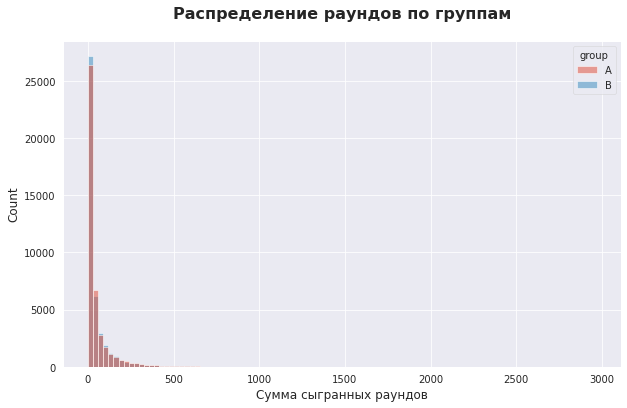

In [93]:
plt.figure(figsize=(10,6))
sns.histplot(data = df, x = df.sum_gamerounds, hue='group', bins=100)
plt.title('Распределение раундов по группам', fontsize=16, fontweight='bold', y=1.05);
plt.xlabel('Сумма сыгранных раундов', fontsize=12);
plt.ylabel('Count', fontsize=12);

Чтобы рассмотреть график чуть ближе, уберем часть верхней границы (q=0.99), оставив часть только ниже этого перцентиля.

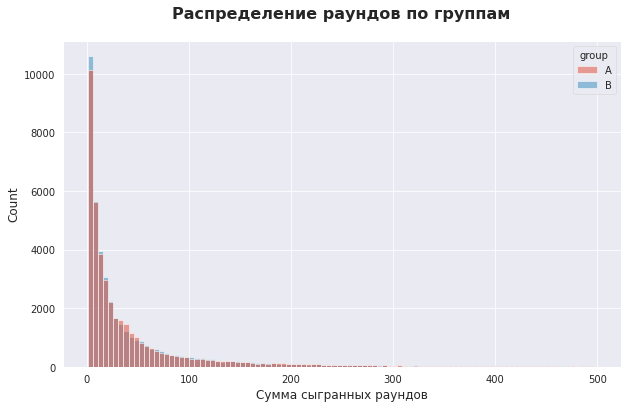

In [94]:
q = df.sum_gamerounds.quantile(.99)

plt.figure(figsize=(10,6))
sns.histplot(data = df[df.sum_gamerounds < q], x = df.sum_gamerounds, hue='group', bins=100)
plt.title('Распределение раундов по группам', fontsize=16, fontweight='bold', y=1.05);
plt.xlabel('Сумма сыгранных раундов', fontsize=12);
plt.ylabel('Count', fontsize=12);

Данное распределение ожидаемо далеко от нормального, больше напоминая логарифмическое - количество игроков уменьшается с каждым сыгранным раундом. 

Кроме того, в мобильных играх часто действует система платежей, значительно ускоряющая прогресс, но немногие готовы платить за игру.

Это подверждается описательной статистикой ниже - 50% всех пользователей сыграли меньше 18 игр.

In [95]:
df.describe()

,sum_gamerounds
count,86194.000000
mean,53.698297
std,104.425174
min,1.000000
25%,6.000000
50%,18.000000
75%,54.000000
max,2961.000000


Проверим размеры получившихся групп и их среднее медиану и стандартное отклонение.

In [96]:
print(len(df[df.group == 'A']))
print(len(df[df.group == 'B']))

# Размеры групп одинаковые

42762
43432


In [97]:
df.groupby('group', as_index=False).agg( \
                        mean = ('sum_gamerounds', 'mean'), \
                        median = ('sum_gamerounds', 'median'),
                        std = ('sum_gamerounds', 'std'))

,group,mean,median,std
0,A,53.667766,18,103.743691
1,B,53.728357,18,105.093012


Среднее и стандартное отклонение тестовой группы чуть выше, а медианы равны. Насколько эта разница существенна? 
Взглянем на нормальность распределения данных в группах и решим, какой из критериев применять.

- *$H_0$* - средние значения кол-ва сыгранных раундов контрольной и тестовой групп статзначимо не различаются.

- *$H_1$* - значимые различия между средними значениями групп имеются. 

In [98]:
control_group = df[df.group == 'A'].sum_gamerounds
test_group = df[df.group == 'B'].sum_gamerounds

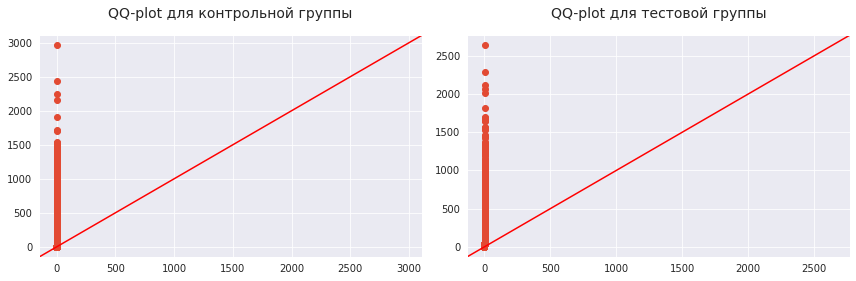

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

sm.qqplot(control_group, line='45', ax=ax1);
ax1.set_title('QQ-plot для контрольной группы', fontsize=14, y=1.05);
ax1.set(xlabel=None);
ax1.set(ylabel=None);

sm.qqplot(test_group, line='45', ax=ax2, c='#4C72B0');
ax2.set_title('QQ-plot для тестовой группы', fontsize=14, y=1.05);
ax2.set(xlabel=None);
ax2.set(ylabel=None);

plt.tight_layout()

Обе группы распределены крайне ненормально, как мы видели выше => необходимо применять непараметрический критерий. Попробуем использовать бутстрап.

In [100]:
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

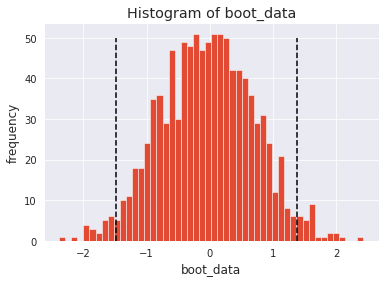

0.954850205957061


In [101]:
bootstrap_mean = get_bootstrap_mean(control_group, test_group)
print(bootstrap_mean['p_value'])

In [102]:
mannwhitneyu(control_group, test_group)

MannwhitneyuResult(statistic=934332123.0, pvalue=0.11766714600761834)

---
- <u>0 входит в доверительный интервал</u> => мы <u>не</u> имеем оснований отклонить нулевую гипотезу. 

- <u>p-value > 0.05</u> => разница между значениями разниц средних (групп A и B) НЕстатзначимая.
То же самое подтверждает тест Манна-Уитни.

<b>Вывод</b>: статзначимой разницы в распределениях параматетра `sum_gamerounds` между группами нет. Оснований отклонить $H_0$ о равенстве среднего числа сыгранных раундов у нас нет.

Перейдём к показателям конверсии.

---

In [103]:
crosstab_1 = pd.crosstab(df['group'], df['retention_1'])
crosstab_2 = pd.crosstab(df['group'], df['retention_7'])

In [104]:
print(crosstab_1, '\n\n')
print(crosstab_2)

retention_1  False  True 
group                    
A            22769  19993
B            23359  20073 


retention_7  False  True 
group                    
A            34277   8485
B            35166   8266


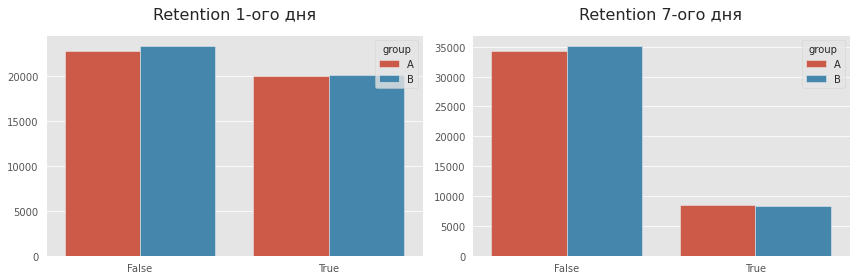

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

sns.countplot(x='retention_1', hue='group', data=df, ax=ax1)
ax1.set_title('Retention 1-ого дня', fontsize=16, y=1.05)
ax1.set(ylabel=None)
ax1.set(xlabel=None)

sns.countplot(x='retention_7', hue='group', data=df, ax=ax2)
ax2.set_title('Retention 7-ого дня', fontsize=16, y=1.05)
ax2.set(ylabel=None)
ax2.set(xlabel=None)

plt.tight_layout()

Из сводной таблицы кажется, что показатель retention 1-ого дня и 7-ого дня значимо не изменился. Посмотрим на процентные соотношения.

In [106]:
retention1_rate_A = df.query('group == "A"').retention_1.sum() / len(df)
retention1_rate_B = df.query('group == "B"').retention_1.sum() / len(df)

retention7_rate_A = df.query('group == "A"').retention_7.sum() / len(df)
retention7_rate_B = df.query('group == "B"').retention_7.sum() / len(df)

In [107]:
print(retention1_rate_A, retention1_rate_B) # в группе B показатель выше на 0.001
print(retention7_rate_A, retention7_rate_B) # в группе A показатель выше примерно на 0.003

0.23195350024363645 0.23288163909320833
0.09844072673271921 0.09589994663201615


`retention_1` чуть увеличился, а `retention_7` немного снизился. Но случайны ли эти изменения?

Обе переменные (group, retention) номинативные, поэтому можем применить критерий хи-квадрат, чтобы узнать, имеется ли взаимосвязь между группой и retention и насколько она значима.

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [108]:
# Retention 1-ого дня

stat_1, p_1, dof_1, expected_1 = chi2_contingency(crosstab_1)
stat_1, p_1

(2.47671866669166, 0.11554308221600512)

In [109]:
# Превышает ли полученное значение статистики значение 95-ого квантиля?

prob = 0.95 
critical = chi2.ppf(prob, dof_1)
if abs(stat_1) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [110]:
# Является ли полученное p-value меньше заданного уровня значимости?

prob = 0.95
alpha = 1.0 - prob
if p_1 <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Мы не можем отклонить $H_0$ об отсутствии взаимосвязи между `group` и `retention_1`. Удержание пользователей после обновления статзначимо не изменилось.

In [111]:
# Retention 7-ого дня

stat_2, p_2, dof_2, expected_2 = chi2_contingency(crosstab_2)
stat_2, p_2

(8.984877907964687, 0.0027222297777463066)

In [112]:
prob = 0.95 
critical = chi2.ppf(prob, dof_2)
if abs(stat_2) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


In [113]:
prob = 0.95
alpha = 1.0 - prob
if p_2 <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Ситуация обратная - спад retention не случаен, и пользователи действительно стали реже (на 2.5%) приходить на 7-ой день после обновления. 

<b>Вывод</b>: мы <u>имеем основания</u> отклонить $H_0$ об отсутствии взаимосвязи между группой и retention 7-го дня.



---
<font size="3"><b>Итог</b>: новое обновление не повлияло на среднее количество сыгранных раундов и retention 1-го дня, но вызвало спад retention 7-го. <u>Обновление нельзя выкатывать</u> - низкая вовлечённость пользователей ведёт к уменьшению количества игроков и, как итог, к меньшему заработку.

<b>Возможная причина и решение</b>: обычно достижение каждого нового уровня заставляет игрока всё больше времени проводить в игре. Так как выход в открытый мир является одним из самых важных событий для любого игрока, его перенос на целых 10 уровней дальше снижает мотивацию - как итог, пользователь реже заходит в игру. 

Если есть проблема с быстрым достижением 30-го уровня, необходимо найти ту границу, которая будет устраивать и сообщество, и разработчиков. Возможно, в следующих экспериментах стоит определить границу на 3-4 уровня выше и, постепенно повышая, смотреть, какова будет реакция игроков. </font>

---